### Movie Recommendation System
**This notebook outlines the concepts involved in building a Complete Recommendation System for recommending Movies to users**

## IMPORT LIBRARIES

In [1]:
%matplotlib inline
import numpy as np 
import pandas as pd
# import cudf
from matplotlib import pyplot as plt
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk

nltk.download('omw-1.4')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...


## LOAD DATASET

### Ratings Data

In [2]:
ratings=pd.read_csv('../input/movie-lens-20m-dataset/ratings.csv')

In [3]:
#splitting data for usability, larger datasets require more than 30GB RAM to hold the Users-Movies matrix
ratings = ratings.iloc[0:1000000,:]

In [4]:
ratings

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580
...,...,...,...,...
999995,6743,1580,4.0,1117760757
999996,6743,1584,3.0,1117760943
999997,6743,1586,3.0,1117761831
999998,6743,1589,4.0,1117761990


### Movies Data

In [5]:
movies_df=pd.read_csv('../input/movie-lens-20m-dataset/movies.csv')

In [6]:
movies = movies_df.loc[movies_df['movieId'].isin(ratings['movieId'].unique())]

In [7]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
27069,130073,Cinderella (2015),Adventure|Children|Drama|Sci-Fi
27078,130219,The Dark Knight (2011),Action|Crime|Drama|Thriller
27116,130462,The Boy (2015),(no genres listed)
27122,130490,Insurgent (2015),Action|Romance|Sci-Fi


In [8]:
movies.reset_index(drop=True, inplace=True)

In [9]:
for i in range(movies.shape[0]):
    movies.at[i,'genres'] = " ".join(movies.at[i,'genres'].split('|')) 

In [10]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
13945,130073,Cinderella (2015),Adventure Children Drama Sci-Fi
13946,130219,The Dark Knight (2011),Action Crime Drama Thriller
13947,130462,The Boy (2015),(no genres listed)
13948,130490,Insurgent (2015),Action Romance Sci-Fi


### Tags Data

In [11]:
tags=pd.read_csv('../input/movie-lens-20m-dataset/tags.csv')

In [12]:
tags

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078
...,...,...,...,...
465559,138446,55999,dragged,1358983772
465560,138446,55999,Jason Bateman,1358983778
465561,138446,55999,quirky,1358983778
465562,138446,55999,sad,1358983772


### Merging Movies and Tags

In [13]:
for j in tags.movieId.unique():
    movies.loc[movies.loc[movies.movieId==j].index,'tags'] = ' '.join(
        [i if type(i)==str else str(i) for i in tags.loc[(tags.movieId == j),'tag'].unique().tolist()]
    )

In [14]:
movies

,movieId,title,genres,tags
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,Watched computer animation Disney animated fea...
1,2,Jumanji (1995),Adventure Children Fantasy,time travel adapted from:book board game child...
2,3,Grumpier Old Men (1995),Comedy Romance,old people that is actually funny sequel fever...
3,4,Waiting to Exhale (1995),Comedy Drama Romance,chick flick revenge characters CLV
4,5,Father of the Bride Part II (1995),Comedy,Diane Keaton family sequel Steve Martin weddin...
...,...,...,...,...
13945,130073,Cinderella (2015),Adventure Children Drama Sci-Fi,Cinderella unoriginal
13946,130219,The Dark Knight (2011),Action Crime Drama Thriller,NaN
13947,130462,The Boy (2015),(no genres listed),NaN
13948,130490,Insurgent (2015),Action Romance Sci-Fi,Action Miles Teller Stupid Young Adult based o...


In [15]:
movies['tags'] = movies['tags'].fillna('')

In [16]:
movies

,movieId,title,genres,tags
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,Watched computer animation Disney animated fea...
1,2,Jumanji (1995),Adventure Children Fantasy,time travel adapted from:book board game child...
2,3,Grumpier Old Men (1995),Comedy Romance,old people that is actually funny sequel fever...
3,4,Waiting to Exhale (1995),Comedy Drama Romance,chick flick revenge characters CLV
4,5,Father of the Bride Part II (1995),Comedy,Diane Keaton family sequel Steve Martin weddin...
...,...,...,...,...
13945,130073,Cinderella (2015),Adventure Children Drama Sci-Fi,Cinderella unoriginal
13946,130219,The Dark Knight (2011),Action Crime Drama Thriller,
13947,130462,The Boy (2015),(no genres listed),
13948,130490,Insurgent (2015),Action Romance Sci-Fi,Action Miles Teller Stupid Young Adult based o...


In [17]:
movies["metadata"] = movies["genres"].astype(str) + ' ' +  movies["tags"].astype(str)

In [18]:
movies

,movieId,title,genres,tags,metadata
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,Watched computer animation Disney animated fea...,Adventure Animation Children Comedy Fantasy Wa...
1,2,Jumanji (1995),Adventure Children Fantasy,time travel adapted from:book board game child...,Adventure Children Fantasy time travel adapted...
2,3,Grumpier Old Men (1995),Comedy Romance,old people that is actually funny sequel fever...,Comedy Romance old people that is actually fun...
3,4,Waiting to Exhale (1995),Comedy Drama Romance,chick flick revenge characters CLV,Comedy Drama Romance chick flick revenge chara...
4,5,Father of the Bride Part II (1995),Comedy,Diane Keaton family sequel Steve Martin weddin...,Comedy Diane Keaton family sequel Steve Martin...
...,...,...,...,...,...
13945,130073,Cinderella (2015),Adventure Children Drama Sci-Fi,Cinderella unoriginal,Adventure Children Drama Sci-Fi Cinderella uno...
13946,130219,The Dark Knight (2011),Action Crime Drama Thriller,,Action Crime Drama Thriller
13947,130462,The Boy (2015),(no genres listed),,(no genres listed)
13948,130490,Insurgent (2015),Action Romance Sci-Fi,Action Miles Teller Stupid Young Adult based o...,Action Romance Sci-Fi Action Miles Teller Stup...


In [19]:
movies.iloc[0]['metadata']

"Adventure Animation Children Comedy Fantasy Watched computer animation Disney animated feature Pixar animation TÃ©a Leoni does not star in this movie Pixar animation family Tom Hanks witty adventure animated clever comedy fantasy bright DARING RESCUES fanciful HEROIC MISSION humorous light rousing TOYS COME TO LIFE UNLIKELY FRIENDSHIPS warm time travel kids movie Disney Tim Allen action figure action figures Buzz Lightyear CG animation toy toys Woody villian hurts toys pixar disney children é˜®ä¸€é¸£ funny 3D Cartoon ya boy cgi rated-G lots of heart Animation want to see again imdb top 250 buddy movie the boys very good Best of Rotten Tomatoes: All Time John Lasseter USA classic avi buy fun Want CGI soothing almost favorite friendship family film cute story voice acting first cgi film Engaging 2009 reissue in Stereoscopic 3-D 55 movies every kid should see--Entertainment Weekly BD-Video CLV DVD-Video kids and family erlend's DVDs innovative dolls National Film Registry Tumey's To See 

### Preprocess the metadata column

In [20]:
pattern = r'\b[^\d\W]+\b'
tokenizer = RegexpTokenizer(pattern)
en_stop = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [21]:
def metadata_preprocess(row):
    # clean and tokenize document string
    row = row.lower()
    tokens = tokenizer.tokenize(row)

    # remove stop words from tokens
    filtered_tokens = [token for token in tokens if not token in en_stop]
    
    # lemmatize tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    # remove words containing less than 2 characters and select the unique words
    clean_tokens = set([token for token in lemmatized_tokens if not len(token) <= 2])
    
    # return the processed document
    return " ".join(clean_tokens)

In [22]:
for i in range(movies.shape[0]):
    movies.at[i,'metadata'] = metadata_preprocess(movies.at[i,'metadata'])

In [23]:
movies.iloc[0]['metadata']

'animated john allen friendship cute first witty warm boy top classic daring hurt tumey movie time tomato travel fantasy national toy video clever registry cartoon almost disney rated buy engaging lot funny villian family see humorous kid vhs star story watched life acting best avi rousing fanciful entertainment feature comedy want action erlend cgi dvd reissue computer weekly hank light come doll heart imdb leoni lasseter heroic tim woody fun unlikely rescue every stereoscopic figure mission rotten favorite buzz film clv lightyear innovative tom soothing adventure animation bright child buddy usa voice pixar good'

## 1. Content Filtering

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['metadata'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=movies.index.tolist())
print(tfidf_df.shape)

(13950, 19829)


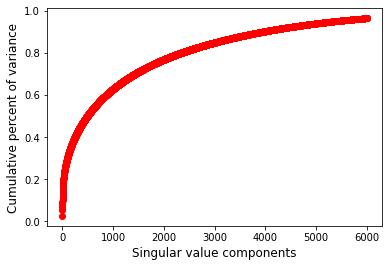

In [25]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=6000)
latent_matrix = svd.fit_transform(tfidf_df)
# plot var expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 12, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

In [26]:
n = 6000
latent_matrix_1_df = pd.DataFrame(latent_matrix[:,0:n], index=movies.title.tolist())

In [27]:
latent_matrix_1_df

,0,1,2,3,4,5,6,7,8,9,...,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999
Toy Story (1995),0.064091,0.046449,0.066816,0.102717,0.042192,0.085885,-0.154993,-0.014727,-0.117122,0.067200,...,-0.000846,0.012140,0.000597,-0.011199,0.002921,-0.004226,0.001933,0.005564,-0.000808,-0.001625
Jumanji (1995),0.044012,0.012441,0.106528,0.062116,-0.000274,0.069279,-0.147195,-0.038706,-0.066372,0.008223,...,-0.005024,0.003726,-0.010357,0.000501,-0.004812,0.002764,-0.000832,0.007058,-0.005027,0.001910
Grumpier Old Men (1995),0.057223,0.057924,0.005851,0.060772,-0.025001,-0.005120,-0.000088,-0.017683,-0.015032,0.011833,...,0.001759,-0.000811,-0.002655,0.002847,0.004798,-0.004632,0.005810,0.003807,0.001658,-0.002395
Waiting to Exhale (1995),0.285430,0.092513,-0.040598,0.145510,-0.100592,-0.044989,0.032640,-0.061315,-0.007132,0.008864,...,0.002935,-0.002009,-0.003444,-0.001263,-0.002939,-0.000765,-0.000438,-0.000838,0.000472,-0.000823
Father of the Bride Part II (1995),0.069335,0.077880,0.029727,0.040481,0.013837,0.036849,-0.064675,0.007502,-0.058845,0.043785,...,-0.012213,0.000436,0.010081,0.007179,-0.002469,0.005432,-0.000956,-0.007876,-0.009010,0.004232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cinderella (2015),0.132031,-0.052108,0.035230,0.038860,0.022491,0.093039,-0.207233,-0.079148,-0.082837,0.021894,...,-0.005103,0.010557,0.001332,0.002231,0.003327,-0.005452,0.001416,0.010466,0.002721,-0.013416
The Dark Knight (2011),0.449781,-0.253287,0.475414,0.103876,0.560061,-0.148627,0.204755,-0.160809,0.081610,-0.215207,...,-0.000012,-0.000070,-0.000069,-0.000080,-0.000419,-0.000117,-0.000027,0.000358,-0.000018,0.000032
The Boy (2015),0.000799,0.000306,0.002265,0.001528,0.000152,0.001445,-0.002475,0.000419,-0.002453,0.001063,...,-0.000209,-0.000478,-0.000414,-0.000557,-0.000329,0.000473,0.000159,0.000092,-0.000351,-0.000245
Insurgent (2015),0.056891,0.016063,0.062029,0.137616,-0.018852,0.010962,-0.066866,-0.068623,0.014866,-0.050677,...,0.006899,-0.000146,-0.001361,0.003124,-0.003206,-0.001713,-0.009043,-0.002551,-0.004866,-0.006188


## 2. Collaborative Filtering

### Create a User-Movies Matrix

In [28]:
user_movies_data=pd.pivot_table(ratings,index='movieId',columns='userId',values='rating',fill_value=0)

In [29]:
user_movies_data

userId,1,2,3,4,5,6,7,8,9,10,...,6734,6735,6736,6737,6738,6739,6740,6741,6742,6743
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0,4,0,0,5,0,4,0,4,...,0.5,4,4,3.0,0.0,4,0.0,4.0,0,4.0
2,3.5,0,0,0,3,0,0,0,0,0,...,0.0,0,0,0.0,0.0,0,0.0,0.0,0,3.0
3,0.0,4,0,0,0,3,3,5,0,0,...,0.0,5,0,0.0,0.0,4,0.0,0.0,0,3.0
4,0.0,0,0,0,0,0,0,0,0,0,...,0.0,0,0,0.0,0.0,1,0.0,0.0,0,0.0
5,0.0,0,0,0,0,0,0,0,0,0,...,0.0,4,3,0.0,0.0,0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130073,0.0,0,0,0,0,0,0,0,0,0,...,0.0,0,0,0.0,0.0,0,0.0,0.0,0,0.0
130219,0.0,0,0,0,0,0,0,0,0,0,...,0.0,0,0,0.0,0.0,0,0.0,0.0,0,0.0
130462,0.0,0,0,0,0,0,0,0,0,0,...,0.0,0,0,0.0,0.0,0,0.0,0.0,0,0.0


In [30]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2500)
latent_matrix_2 = svd.fit_transform(user_movies_data)
latent_matrix_2_df = pd.DataFrame(latent_matrix_2, index=movies.title.tolist())

In [31]:
latent_matrix_2_df

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
Toy Story (1995),131.725801,20.515263,30.862063,6.919678,15.023060,39.989191,-1.605104,42.824279,4.800610,0.912099,...,0.028723,0.043133,-0.078670,0.125778,0.045922,-0.010118,0.029637,0.036379,0.060050,0.021723
Jumanji (1995),59.848189,17.777476,29.454561,-15.631754,-8.244621,8.428229,-12.131184,3.483945,10.879191,-0.823042,...,0.028060,-0.050693,-0.027348,-0.011512,0.080989,0.096630,0.006409,0.005021,0.061457,-0.155745
Grumpier Old Men (1995),26.552317,18.459385,9.414824,-12.562718,-7.180238,0.696286,-1.443366,25.135679,-6.835289,-6.915899,...,-0.097095,-0.096976,0.057686,-0.153968,-0.046316,-0.027946,-0.102809,-0.125919,-0.012682,0.056533
Waiting to Exhale (1995),6.411919,7.981412,1.068361,-2.492930,-4.490516,-0.876583,1.342409,3.984512,0.341844,0.225349,...,0.178518,0.354353,0.048342,-0.140492,-0.206067,0.317594,-0.330887,-0.147561,0.353070,-0.442289
Father of the Bride Part II (1995),23.222092,18.842160,13.724218,-14.217174,-10.549673,2.929064,-0.196759,23.250122,-4.973555,-6.918588,...,0.124978,0.069586,0.036532,0.088664,-0.012208,0.058603,-0.132937,-0.052574,0.070226,-0.010635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cinderella (2015),0.089671,-0.047480,-0.025359,-0.096487,-0.074203,0.018442,-0.063795,-0.030838,-0.086472,0.043109,...,0.006396,-0.002744,-0.007710,0.006135,-0.007718,0.001623,0.000501,0.011473,-0.012858,0.001939
The Dark Knight (2011),0.111263,-0.120378,0.175471,-0.059602,-0.054638,-0.005287,-0.147393,0.022524,-0.244545,0.062206,...,-0.003409,-0.040760,-0.048243,-0.013723,-0.014807,0.001552,0.031047,0.039259,0.050800,-0.029538
The Boy (2015),0.092198,-0.052581,0.014153,0.142496,0.018235,0.006396,-0.005400,-0.027855,0.002332,0.084031,...,-0.037722,-0.016044,0.014573,0.027267,-0.114918,0.059703,-0.031352,0.010879,0.016600,0.125163
Insurgent (2015),0.143689,-0.105553,-0.003071,-0.117400,-0.241229,0.089125,-0.018856,0.137115,0.027784,0.090135,...,-0.002272,0.001657,0.004384,0.006952,0.017404,-0.002576,0.003970,-0.008754,0.003248,-0.009937


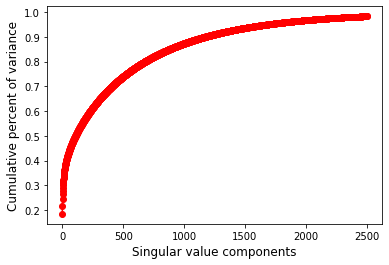

In [32]:
# plot variance expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 12, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

In [33]:
from sklearn.metrics.pairwise import cosine_similarity
# take the latent vectors for a selected movie from both content 
# and collaborative matrixes
a_1 = np.array(latent_matrix_1_df.loc['Toy Story (1995)']).reshape(1, -1)
a_2 = np.array(latent_matrix_2_df.loc["Toy Story (1995)"]).reshape(1, -1)

# calculate the similartity of this movie with the others in the list
score_1 = cosine_similarity(latent_matrix_1_df, a_1).reshape(-1)
score_2 = cosine_similarity(latent_matrix_2_df, a_2).reshape(-1)

# an average measure of both content and collaborative 
hybrid = ((score_1 + score_2)/2.0)

# form a data frame of similar movies 
dictDf = {'content': score_1 , 'collaborative': score_2, 'hybrid': hybrid} 
# dictDf = {'collaborative': score_2} 
similar = pd.DataFrame(dictDf, index = latent_matrix_2_df.index )

#sort it on the basis of either: content, collaborative or hybrid, 
# here : content
similar.sort_values('content', ascending=False, inplace=True)

similar[1:].head(11)

,content,collaborative,hybrid
Toy Story 2 (1999),0.638552,0.537767,0.588160
"Bug's Life, A (1998)",0.271633,0.462874,0.367254
"Monsters, Inc. (2001)",0.267497,0.469501,0.368499
Finding Nemo (2003),0.264637,0.460486,0.362562
Pinocchio (1940),0.242044,0.317876,0.279960
Shrek (2001),0.240840,0.483666,0.362253
Cars (2006),0.235244,0.235667,0.235456
Beauty and the Beast (1991),0.221464,0.476429,0.348946
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),0.218440,0.518311,0.368375
Toy Story 3 (2010),0.216108,0.242049,0.229079


In [34]:
similar.sort_values('collaborative', ascending=False, inplace=True)

similar[1:].head(11)

,content,collaborative,hybrid
Star Wars: Episode IV - A New Hope (1977),0.150634,0.579136,0.364885
Independence Day (a.k.a. ID4) (1996),0.094303,0.576168,0.335235
Star Wars: Episode VI - Return of the Jedi (1983),0.092820,0.554524,0.323672
Forrest Gump (1994),0.133244,0.544860,0.339052
Mission: Impossible (1996),0.047269,0.542966,0.295117
Back to the Future (1985),0.160742,0.541562,0.351152
Toy Story 2 (1999),0.638552,0.537767,0.588160
Aladdin (1992),0.143335,0.536714,0.340025
Jurassic Park (1993),0.150024,0.533311,0.341668
Willy Wonka & the Chocolate Factory (1971),0.113868,0.530748,0.322308


In [35]:
similar.sort_values('hybrid', ascending=False, inplace=True)

similar[1:].head(11)

,content,collaborative,hybrid
Toy Story 2 (1999),0.638552,0.537767,0.588160
"Monsters, Inc. (2001)",0.267497,0.469501,0.368499
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),0.218440,0.518311,0.368375
"Bug's Life, A (1998)",0.271633,0.462874,0.367254
Star Wars: Episode IV - A New Hope (1977),0.150634,0.579136,0.364885
Finding Nemo (2003),0.264637,0.460486,0.362562
Shrek (2001),0.240840,0.483666,0.362253
Back to the Future (1985),0.160742,0.541562,0.351152
"Lion King, The (1994)",0.169260,0.529097,0.349178
Beauty and the Beast (1991),0.221464,0.476429,0.348946


## 3. Hybrid Recommendation System

In [36]:
def recommend_similar_movies(title):
    # take the latent vectors for a selected movie from both content 
    # and collaborative matrixes
    a_1 = np.array(latent_matrix_1_df.loc[title]).reshape(1, -1)
    a_2 = np.array(latent_matrix_2_df.loc[title]).reshape(1, -1)

    # calculate the similartity of this movie with the others in the list
    score_1 = cosine_similarity(latent_matrix_1_df, a_1).reshape(-1)
    score_2 = cosine_similarity(latent_matrix_2_df, a_2).reshape(-1)

    # an average measure of both content and collaborative 
    hybrid = ((score_1 + score_2)/2.0)

    # form a data frame of similar movies 
    dictDf = {'content': score_1 , 'collaborative': score_2, 'hybrid': hybrid} 
    similar = pd.DataFrame(dictDf, index = latent_matrix_2_df.index )

    #sort it on the basis of either: content, collaborative or hybrid
    similar.sort_values('hybrid', ascending=False, inplace=True)

    print(similar[1:].head(11))

In [37]:
recommend_similar_movies("GoldenEye (1995)")

                                    content  collaborative    hybrid
Tomorrow Never Dies (1997)         0.438942       0.411379  0.425160
True Lies (1994)                   0.139624       0.601935  0.370779
Die Hard: With a Vengeance (1995)  0.081312       0.601374  0.341343
World Is Not Enough, The (1999)    0.319637       0.340583  0.330110
Terminator 2: Judgment Day (1991)  0.129769       0.528439  0.329104
Batman Forever (1995)              0.062047       0.593417  0.327732
Fugitive, The (1993)               0.089518       0.560057  0.324788
Batman (1989)                      0.071705       0.576117  0.323911
Stargate (1994)                    0.059247       0.558193  0.308720
Jurassic Park (1993)               0.062788       0.547042  0.304915
Goldfinger (1964)                  0.309926       0.298597  0.304262


In [38]:
recommend_similar_movies("Mission: Impossible (1996)")

                                                    content  collaborative  \
Independence Day (a.k.a. ID4) (1996)               0.098219       0.669430   
Rock, The (1996)                                   0.070538       0.644609   
Twister (1996)                                     0.062651       0.610472   
Mission: Impossible II (2000)                      0.210069       0.414319   
Jurassic Park (1993)                               0.070370       0.547185   
Speed (1994)                                       0.070507       0.540271   
Star Wars: Episode VI - Return of the Jedi (1983)  0.078442       0.519486   
GoldenEye (1995)                                   0.128592       0.468866   
Star Wars: Episode IV - A New Hope (1977)          0.057743       0.537675   
True Lies (1994)                                   0.087247       0.504278   
Terminator 2: Judgment Day (1991)                  0.083866       0.506461   

                                                     hybrid  
I

## 4. Matrix Factorization Recommender

- R – The user-movie rating matrix
- K – Number of latent features
- alpha – Learning rate for stochastic gradient descent
- beta – Regularization parameter for bias
- iterations – Number of iterations to perform stochastic gradient descent

In [39]:
class MF():

    # Initializing the user-movie rating matrix, no. of latent features, alpha and beta.
    def __init__(self, R, K, alpha, beta, iterations):
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations

    # Initializing user-feature and movie-feature matrix 
    def train(self):
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initializing the bias terms
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])

        # List of training samples
        self.samples = [
        (i, j, self.R[i, j])
        for i in range(self.num_users)
        for j in range(self.num_items)
        if self.R[i, j] > 0
        ]

        # Stochastic gradient descent for given number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 20 == 0:
                print("Iteration: %d ; error = %.4f" % (i+1, mse))

        return training_process

    # Computing total mean squared error
    def mse(self):
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    # Stochastic gradient descent to get optimized P and Q matrix
    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.get_rating(i, j)
            e = (r - prediction)

            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])

            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

    # Ratings for user i and moive j
    def get_rating(self, i, j):
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    # Full user-movie rating matrix
    def full_matrix(self):
        return mf.b + mf.b_u[:,np.newaxis] + mf.b_i[np.newaxis:,] + mf.P.dot(mf.Q.T)

In [40]:
R= np.array(user_movies_data)

In [41]:
mf = MF(R, K=20, alpha=0.001, beta=0.01, iterations=100)
training_process = mf.train()
print()
print("P x Q:")
print(mf.full_matrix())
print()

Iteration: 20 ; error = 859.2184
Iteration: 40 ; error = 841.1903
Iteration: 60 ; error = 807.6177
Iteration: 80 ; error = 772.6105
Iteration: 100 ; error = 742.1671

P x Q:
[[3.89679828 4.5780518  4.38730123 ... 3.80231757 4.38592198 3.47588207]
 [3.65554807 3.83827422 3.77790414 ... 3.27056197 3.82584825 2.99932201]
 [3.39987285 3.75954376 3.57215357 ... 3.15228439 3.64836256 2.95763481]
 ...
 [3.63969769 4.03704117 3.99175828 ... 3.64238107 4.06470248 3.41807934]
 [3.35378085 3.73597271 3.79780459 ... 3.38349599 3.82625898 3.15497555]
 [3.68458385 4.00732029 4.0261451  ... 3.65960042 4.08398276 3.41258993]]



**Note: As this is computationally expensive so we did only 100 iterations, though the error is still high.**